# Exploration of phonetic embeddings

In this notebook we will try to visualize embeddings of IPA characters and interpret them.
Our phonetic encoding model works at character level. It has learned a different embedding for each IPA character during its training.
We expect embedding of close such as in the IPA graph: 

![IPA Graph](https://d3uxfe7dw0hhy7.cloudfront.net/acip/assets/course/ipachart/IPA2005.png) 

In [ ]:
import mlflow
import torch
from src.pairing.model.phonetic_siamese import PhoneticSiamese

import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Load model from MLFlow experiment

In [7]:
model_uri = "C:/Users/simon/Projets/FindingMnemo/mlruns/264600683054775930/b8f11dc2d5264b25af3ea01f66f52833/artifacts/model" # mlflow.artifacts.download_artifacts("")
loaded_model = mlflow.pytorch.load_model(model_uri)

Get embeddings stored in the model and vocabulary associated with each row.

In [15]:
vocabulary = loaded_model.vocabulary
embedding = loaded_model.embedding.weight.detach().numpy()

## Visualization of embeddings using UMAP

*"UMAP is a general purpose manifold learning and dimension reduction algorithm."*
We use it in order to keep distances from large dimensions similar while reducing them to 2 dimension so that we can plot them on a graph.

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
reducer = umap.UMAP()
scaled_embedding = StandardScaler().fit_transform(embedding)
umapped_embedding = reducer.fit_transform(scaled_embedding)
umapped_embedding.shape

(588, 2)

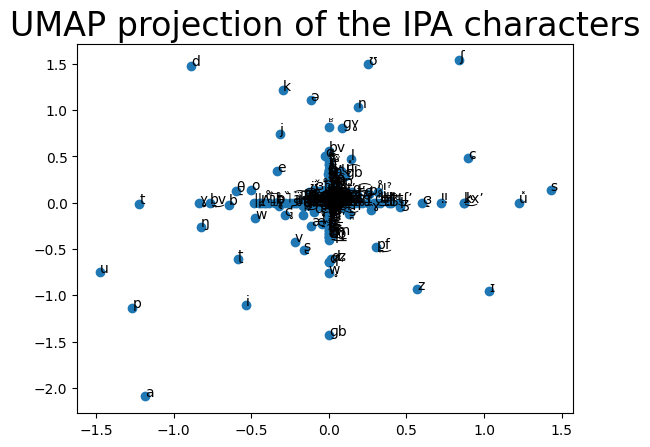

In [31]:
z = embedding[:, 0]
y = embedding[:, 1]
d = {x: y for y,x in vocabulary.items()}
fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(range(len(z)-1)):
    ax.annotate(d[i], (z[i], y[i]))

plt.title('UMAP projection of the IPA characters', fontsize=24)
plt.show()